In [29]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [5]:
f = pd.read_excel('/ocean/eolson/MEOPAR/obs/PSFCitSci/All_Yrs_Nutrients_2018-01-31_EOEdit.xlsx',
                 sheetname = 5)
f.keys()

Index(['Crew', 'Date (dd/mm/yyyy)', 'Time (Local)', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Station', 'Depth', 'NO3+NO',
       'PO4', 'Samples missing!', 'Unnamed: 12', 'Samples in lab.'],
      dtype='object')

In [6]:
f = f.drop(f.keys()[11:], axis=1)

In [7]:
f.shape

(1553, 11)

In [10]:
f = f.dropna(subset = ['Date (dd/mm/yyyy)', 'Time (Local)', 'Latitude', 'Longitude', 'Depth', 'NO3+NO'])

In [11]:
f[:5]

,Crew,Date (dd/mm/yyyy),Time (Local),Lat_reported,Long_reported,Latitude,Longitude,Station,Depth,NO3+NO,PO4
0,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.920000,-125.000,SS-46131,0,18.491,1.951
1,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.920000,-125.000,SS-46131,0,18.662,1.863
2,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.920000,-125.000,SS-46131,0,19.621,1.561
7,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,0,24.163,2.237
8,Campbell River,2016-02-16,09:58:00,50° 04.900,125° 15.900,50.081667,-125.265,CR-2,20,24.326,2.787


In [12]:
f.shape

(1374, 11)

In [13]:
local = pytz.timezone ("America/Los_Angeles")

In [14]:
import datetime

In [15]:
datetimes = np.array([])
for index in f.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(f['Date (dd/mm/yyyy)'][index])), 
                          f['Time (Local)'][index])
    datetimes = np.append(datetimes, dt)

In [16]:
f.shape

(1374, 11)

In [17]:
datetimes.shape

(1374,)

In [18]:
f = f.assign(datetime = datetimes)

In [19]:
f.shape

(1374, 12)

In [20]:
f.Crew.unique()

array(['Sentry Shoal', 'Campbell River', 'Lund', 'Powell River',
       'Steveston', 'Nanaimo/Qualicum', 'Baynes Sound', 'Cowichan Bay',
       'Galiano Island', 'Ladysmith', 'Irvines-Sechelt',
       'Malaspina Strait'], dtype=object)

In [23]:
list_of_months = np.array([])
list_of_cs_ni = np.array([])
list_of_model_ni = np.array([])
for n in f.index:
    Yind, Xind = geo_tools.find_closest_model_point(f.Longitude[n], f.Latitude[n], X, Y, land_mask = bathy.mask)
    if f['Depth'][n] == 0:
        depth = 0
    elif f['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(f['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date.minute) / 60
        ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
        if f['NO3+NO'][n] == '<0':
            list_of_cs_ni = np.append(list_of_cs_ni, 0)
        elif f['NO3+NO'][n] == '30..09':
            list_of_cs_ni = np.append(list_of_cs_ni, 30.09)
        else:
            list_of_cs_ni = np.append(list_of_cs_ni, float(f['NO3+NO'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_months = np.append(list_of_months, date.month)

In [24]:
list_of_model_ni.shape

(1363,)

In [25]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

In [27]:
list_of_cs_ni.shape

(1363,)

In [30]:
colours = cm.rainbow(np.linspace(0,1,10))

bias =  -0.3093787598033515
RMSE = 7.845008862344129
Willmott = 0.788191622671147


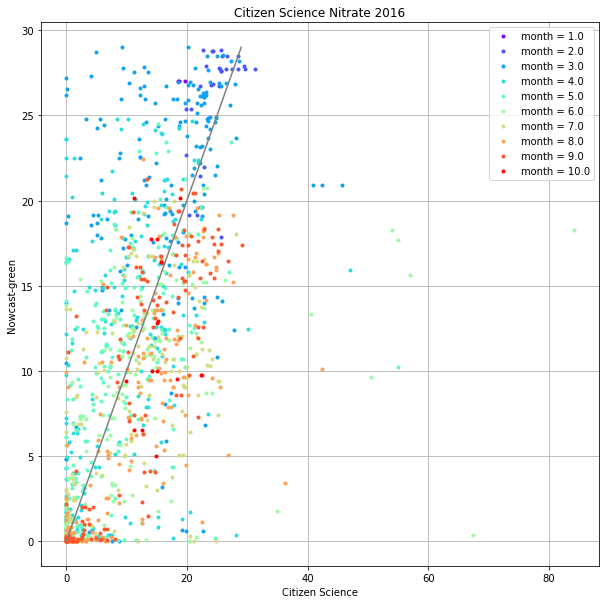

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
for month, colour in zip(np.unique(list_of_months), colours):
    ax.plot(list_of_cs_ni[list_of_months == month], list_of_model_ni[list_of_months == month],  
            '.', color = colour, label = 'month = ' + str(month))
ax.plot(np.arange(0,30), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Nitrate 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

In [98]:
g = pd.read_excel('/ocean/eolson/MEOPAR/obs/PSFCitSci/All_Yrs_Nutrients_2018-01-31_EOEdit.xlsx', sheetname =6)
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time (Local)', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Depth', 'SiO2 µM', 'Date doesn't match',
       'Unnamed: 10'],
      dtype='object')

In [99]:
g[:5]

,Site ID,DDMMYYYY,Time (Local),Lat_reported,Long_reported,Latitude,Longitude,Depth,SiO2 µM,Date doesn't match,Unnamed: 10
0,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,42.35500,NaN,NaN
1,BS-1,2016-06-08,16:30:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,4.91890,NaN,NaN
2,BS-1,2016-06-28,14:56:00,49° 36.500,124° 52.000,49.608333,-124.866667,20,38.35056,NaN,NaN
3,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.16012,NaN,NaN
4,BS-1,2016-07-20,13:45:00,49° 36.500,124° 52.000,49.608333,-124.866667,S,29.37894,NaN,NaN


In [100]:
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time (Local)', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Depth', 'SiO2 µM', 'Date doesn't match',
       'Unnamed: 10'],
      dtype='object')

In [101]:
g = g.dropna(subset = ['DDMMYYYY', 'Time (Local)', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM'])

In [44]:
datetimes = np.array([])
for index in g.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(g['DDMMYYYY'][index])), 
                          g['Time (Local)'][index])
    datetimes = np.append(datetimes, dt)
g = g.assign(datetime = datetimes)

In [46]:
g.Depth.unique()

array([20, 'S', 10, 5, 0, 30], dtype=object)

In [47]:
list_of_cs_si = np.array([])
list_of_model_si = np.array([])
list_of_months2 = np.array([])
for n in g.index:
    Yind, Xind = geo_tools.find_closest_model_point(g.Longitude[n], g.Latitude[n], 
                                                    X, Y, land_mask = bathy.mask)
    if g['Depth'][n] == 0:
        depth = 0
    elif g['Depth'][n] == 20:
        depth = 18
    elif g['Depth'][n] == 10:
        depth = 9
    elif g['Depth'][n] == 5:
        depth = 4
    elif g['Depth'][n] == 30:
        depth = 21
    elif g['Depth'][n] == 'S':
        depth = 0
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(g['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date.minute) / 60
        si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        if g['SiO2 µM'][n] < 0:
            list_of_cs_si = np.append(list_of_cs_si, 0)
        else:
            list_of_cs_si = np.append(list_of_cs_si, float(g['SiO2 µM'][n]))
        list_of_model_si = np.append(list_of_model_si, si_val)
        list_of_months2 = np.append(list_of_months2, date.month)

In [48]:
np.unique(list_of_months2)

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

bias =  -16.033835333355604
RMSE = 20.87688534183842
Willmott = 0.6293482094352933


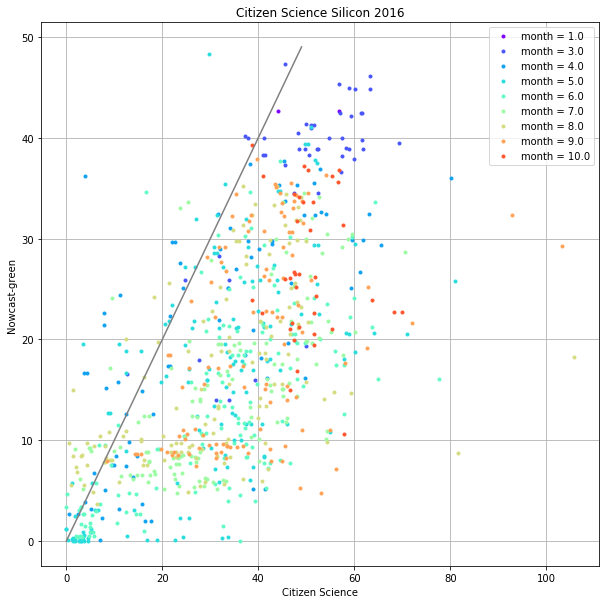

In [50]:
fig, ax = plt.subplots(figsize = (10,10))
for month, colour in zip(np.unique(list_of_months2), colours):
    ax.plot(list_of_cs_si[list_of_months2 == month], list_of_model_si[list_of_months2 == month],  
            '.', color = colour, label = 'month = ' + str(month))
ax.plot(np.arange(0,50), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Silicon 2016')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

In [51]:
f.keys()

Index(['Crew', 'Date (dd/mm/yyyy)', 'Time (Local)', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Station', 'Depth', 'NO3+NO',
       'PO4', 'datetime'],
      dtype='object')

In [52]:
g.keys()

Index(['Site ID', 'DDMMYYYY', 'Time (Local)', 'Lat_reported', 'Long_reported',
       'Latitude', 'Longitude', 'Depth', 'SiO2 µM', 'datetime'],
      dtype='object')

In [68]:
g = g.rename(columns = {'Site ID': 'Station'})

In [71]:
g = g.rename(columns = {'DDMMYYYY': 'Date (dd/mm/yyyy)'})

In [53]:
g.loc[g['Depth'] == 'S', 'Depth'] = 0

In [72]:
g.keys()

Index(['Station', 'Date (dd/mm/yyyy)', 'Time (Local)', 'Lat_reported',
       'Long_reported', 'Latitude', 'Longitude', 'Depth', 'SiO2 µM',
       'datetime'],
      dtype='object')

In [87]:
both = pd.merge(f.drop_duplicates(), g.drop_duplicates(), on=['datetime', 'Latitude', 'Longitude', 'Depth', 
                          'Station', 'Time (Local)', 'Date (dd/mm/yyyy)', 'Lat_reported',
                         'Long_reported']).drop_duplicates(subset=['Time (Local)', 'Date (dd/mm/yyyy)',
                                                                  'Latitude', 'Longitude', 'NO3+NO', 'SiO2 µM',
                                                                  'Depth', 'datetime'])
both.shape

(982, 13)

In [88]:
both[:5]

,Crew,Date (dd/mm/yyyy),Time (Local),Lat_reported,Long_reported,Latitude,Longitude,Station,Depth,NO3+NO,PO4,datetime,SiO2 µM
0,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.92,-125.0,SS-46131,0,18.491,1.951,2016-01-22 17:30:00,44.03363
1,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.92,-125.0,SS-46131,0,18.491,1.951,2016-01-22 17:30:00,56.75423
2,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.92,-125.0,SS-46131,0,18.662,1.863,2016-01-22 17:30:00,44.03363
3,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.92,-125.0,SS-46131,0,18.662,1.863,2016-01-22 17:30:00,56.75423
4,Sentry Shoal,2016-01-22,17:30:00,49° 55.200,125° 00.000,49.92,-125.0,SS-46131,0,19.621,1.561,2016-01-22 17:30:00,44.03363


In [89]:
both.Depth.unique()

array([ 0, 20])

In [90]:
list_of_cs_si3 = np.array([])
list_of_model_si3 = np.array([])
list_of_cs_ni3 = np.array([])
list_of_model_ni3 = np.array([])
list_of_months3 = np.array([])
for n in both.index:
    Yind, Xind = geo_tools.find_closest_model_point(both.Longitude[n], 
                                                        both.Latitude[n], 
                                                        X, Y, land_mask = bathy.mask)
    if both['Depth'][n] == 0:
        depth = 0
    elif both['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(both['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date.minute) / 60
        si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                   (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))

        if both['SiO2 µM'][n] < 0:
            list_of_cs_si3 = np.append(list_of_cs_si3, 0)
        else:
            list_of_cs_si3 = np.append(list_of_cs_si3, float(both['SiO2 µM'][n]))
        if both['NO3+NO'][n] == '<0':
            list_of_cs_ni3 = np.append(list_of_cs_ni3, 0)
        else:
            list_of_cs_ni3 = np.append(list_of_cs_ni3, float(both['NO3+NO'][n]))
        list_of_model_si3 = np.append(list_of_model_si3, si_val)
        list_of_model_ni3 = np.append(list_of_model_ni3, ni_val)
        list_of_months3 = np.append(list_of_months3, date.month)

In [91]:
list_of_cs_si3.shape

(976,)

In [92]:
list_of_model_ni3.shape

(976,)

In [93]:
list_of_model_si3.shape

(976,)

In [94]:
np.unique(list_of_months3)

array([ 1.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

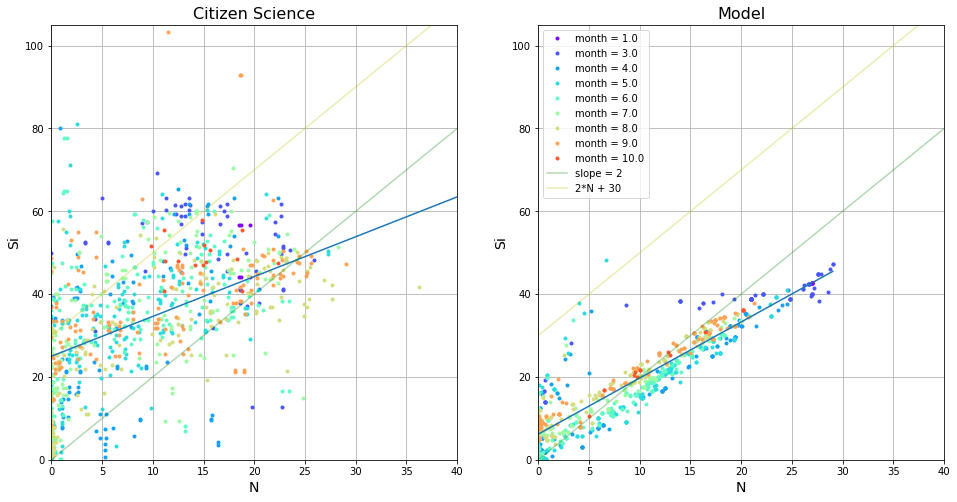

In [95]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
for month, colour in zip(np.unique(list_of_months3), colours):
    ax[0].plot(list_of_cs_ni3[list_of_months3 == month], list_of_cs_si3[list_of_months3 == month],  
            '.', color = colour, label = 'month = ' + str(month))
ax[0].plot(np.unique(list_of_cs_ni3), 
           np.poly1d(np.polyfit(list_of_cs_ni3, list_of_cs_si3, 1))(np.unique(list_of_cs_ni3)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
for month, colour in zip(np.unique(list_of_months3), colours):
    ax[1].plot(list_of_model_ni3[list_of_months3 == month], list_of_model_si3[list_of_months3 == month],  
            '.', color = colour, label = 'month = ' + str(month))
ax[1].plot(np.unique(list_of_model_ni3), 
           np.poly1d(np.polyfit(list_of_model_ni3, 
                                list_of_model_si3, 1))(np.unique(list_of_model_ni3)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [102]:
m1, b1 = np.polyfit(list_of_cs_ni3, list_of_cs_si3, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni3, list_of_model_si3, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 0.9617341040102036
CitSci y int = 25.004353703234774
model slope = 1.3537999041601911
model y int = 6.204495833723717
